In [9]:
#All imported libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import pandas as pd
import re
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np

Part 1 Task 1

In [10]:

# download the necessary resources. 
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(txt):
    if pd.isnull(txt):
      return ''
    #lowercasing text
    txt = txt.lower()
    #Removing excess whitespace, tabs and new lines
    txt = re.sub(r"\s+", " ", txt)
    #remove special characters
    txt = re.sub(r"[^\w\s]+|<|>", "", txt)
    #numbers replaced with "<NUM>"#
    txt = re.sub(r"\d+", "NUM", txt)
    #Dates replaced with "<DATE>"#
    txt = re.sub(r"\d{4}-\d{2}-\d{2}", "DATE", txt)
    #Emails replaces with "<EMAIL>"#
    txt = re.sub(r"\S+@\S+", "EMAIL", txt)
    #URLS replaces with "<URL>"
    txt = re.sub(r"http\S+", "URL", txt)

    return txt

def tokenize_text(df, column):
    # Apply clean_text function to the text in the specified column
    df['clean_text'] = df[column].apply(clean_text)
    # Tokenize the text
    df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)
    return df

def remove_stopwords(df):
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stopwords])
    # Compute the size of the vocabulary before and after removing stopwords
    vocab_before = len(set([word for tokens in df['tokens'] for word in tokens]))
    vocab_after = len(set([word for tokens in df['tokens_no_stopwords'] for word in tokens]))
    if vocab_before > 0:
        reduction_rate_stopwords = (vocab_before - vocab_after) / vocab_before
    else:
        reduction_rate_stopwords = 0
    print(f"\nVocabulary size before removing stopwords: {vocab_before}")
    print(f"Vocabulary size after removing stopwords: {vocab_after}")
    print(f"Reduction rate after removing stopwords: {reduction_rate_stopwords:.2%}")
    return df

def apply_stemming(df):
    # Apply stemming
    stemmer = nltk.stem.SnowballStemmer('english')
    df['tokens_stemmed'] = df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    # Compute the size of the vocabulary before and after stemming
    vocab_before = len(set([word for tokens in df['tokens_no_stopwords'] for word in tokens]))
    vocab_after = len(set([word for tokens in df['tokens_stemmed'] for word in tokens]))
    if vocab_before > 0:
        reduction_rate_stemming = (vocab_before - vocab_after) / vocab_before
    else:
        reduction_rate_stemming = 0
    print(f"Vocabulary size after stemming: {vocab_after}")
    print(f"Reduction rate after stemming: {reduction_rate_stemming:.2%}\n")
    return df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Part 1 Task 2


100 most common words in the data before removing stopwords and stemming:
the: 9487
of: 4965
to: 4888
and: 4697
a: 3379
in: 3108
is: 2317
that: 2203
NUM: 2070
for: 1552
it: 1344
are: 1233
on: 1162
with: 1159
this: 1151
you: 1141
as: 1088
be: 925
i: 869
by: 839
have: 788
not: 787
was: 785
from: 709
at: 707
or: 687
we: 623
they: 601
its: 594
but: 592
your: 555
has: 543
an: 520
their: 515
can: 497
all: 494
will: 487
more: 473
about: 462
if: 449
us: 444
one: 423
what: 420
who: 417
he: 417
were: 390
which: 388
so: 387
there: 378
people: 368
our: 362
his: 357
these: 348
been: 346
no: 340
like: 327
would: 321
do: 320
when: 305
trump: 301
time: 291
some: 282
also: 276
up: 271
new: 270
had: 268
out: 268
how: 264
blockchain: 260
my: 259
into: 254
other: 250
any: 245
just: 245
now: 234
said: 232
many: 227
only: 224
than: 220
market: 216
next: 212
even: 211
URL: 208
them: 205
being: 204
over: 204
after: 203
could: 201
think: 200
because: 197
most: 196
very: 193
way: 191
then: 191
government: 190
s

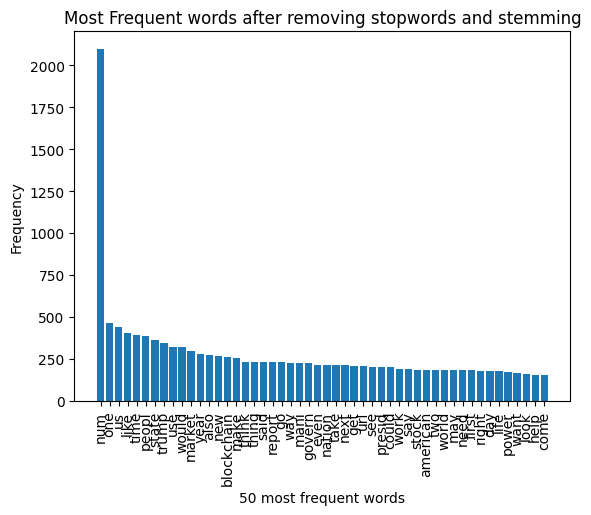

Median article length: 468.5


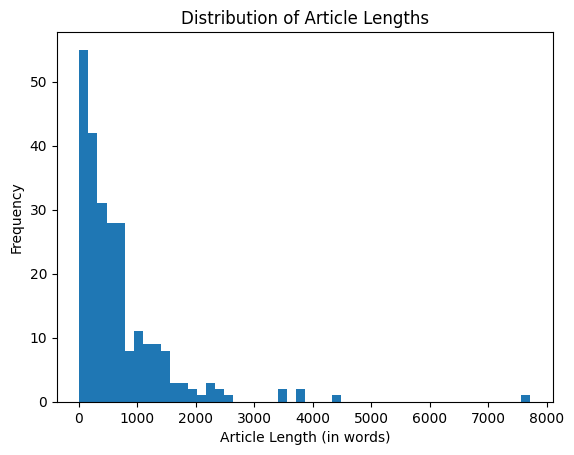

In [11]:
#In this cell we try to find interesting things about the FakeNewsCorpus dataset

# read the csv file
url = 'https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv'
df = pd.read_csv(url)


# Tokenize the text
df = tokenize_text(df, 'content')

# Create a frequency distribution of words in the dataset
all_words = [word for tokens in df['tokens'] for word in tokens]
freq_dist = nltk.FreqDist(all_words)

# Print the 100 most common words
print("100 most common words in the data before removing stopwords and stemming:")
for word, frequency in freq_dist.most_common(100):
    print(f"{word}: {frequency}")

# Remove stopwords
df = remove_stopwords(df)

# Apply stemming
df = apply_stemming(df)

# Create a frequency distribution of words in the dataset
all_words = [word for tokens in df['tokens_stemmed'] for word in tokens]
freq_dist = nltk.FreqDist(all_words)

# Print the 100 most common words
print("100 most common words in the data after removing stopwords and stemming:")
for word, frequency in freq_dist.most_common(100):
    print(f"{word}: {frequency}")

top_words = freq_dist.most_common(100)

# This counts the frequency of each word
word_freq = Counter(all_words)

# We get the 50 most frequent words
top_50 = word_freq.most_common(50)

# Plot a bar chart of the top 50 words
plt.bar([word[0] for word in top_50], [word[1] for word in top_50])
plt.xticks(rotation=90)
plt.title('Most Frequent words after removing stopwords and stemming')
plt.xlabel("50 most frequent words")
plt.ylabel("Frequency")
plt.show()

# Create a list of article lengths
article_lengths = [len(article.split()) for article in df['content']]

# Calculate the median article length
median_article_length = statistics.median(article_lengths)
print(f"Median article length: {median_article_length}")

# Plot a histogram of the article lengths
plt.hist(article_lengths, bins=50)
plt.title('Distribution of Article Lengths')
plt.xlabel('Article Length (in words)')
plt.ylabel('Frequency')
plt.show()

Part 1 Task 3

In [12]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import pandas as pd
df = pd.read_csv('news_cleaned_2018_02_13.csv', dtype={0: str, 1: str})

columns = df.columns

# Print the column names
print(columns)

In [ ]:
import numpy as np
#Count each type. 
df['type'].value_counts()

#Assign label 1 to reliable articles and the rest 0. 
df['label'] = 0
df.loc[(df['type'] == 'political') | (df['type'] == 'reliable'), 'label'] = 1
print(df['label'])

print(np.shape(df['content']))
print(df['label'].shape)

In [ ]:
from sklearn.model_selection import train_test_split




# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.90, random_state=42)
# Print the shapes of the training and test sets
print('Training Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import pandas as pd
import re
import csv
import math

# download the necessary resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(txt):
    if pd.isna(txt):
        return ''
    #lowercasing text
    txt = txt.lower()
    #Removing excess whitespace, tabs and new lines
    txt = re.sub(r"\s+", " ", txt)
    #remove special characters
    txt = re.sub(r"[^\w\s]+|<|>", "", txt)
    #numbers replaced with "<NUM>"#
    txt = re.sub(r"\d+", "NUM", txt)
    #Dates replaced with "<DATE>"#
    txt = re.sub(r"\d{4}-\d{2}-\d{2}", "DATE", txt)
    #Emails replaces with "<EMAIL>"#
    txt = re.sub(r"\S+@\S+", "EMAIL", txt)
    #URLS replaces with "<URL>"
    txt = re.sub(r"http\S+", "URL", txt)

    return txt

def tokenize_text(df):
    # Apply clean_text function to the text in the specified column
    df['clean_text'] = df.apply(clean_text)
    # Tokenize the text
    df['tokens'] = df['clean_text'].apply(nltk.word_tokenize)
    return df

def remove_stopwords(df):
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stopwords])
    # Compute the size of the vocabulary before and after removing stopwords
    vocab_before = len(set([word for tokens in df['tokens'] for word in tokens]))
    vocab_after = len(set([word for tokens in df['tokens_no_stopwords'] for word in tokens]))
    reduction_rate_stopwords = (vocab_before - vocab_after) / vocab_before
    print(f"Vocabulary size before removing stopwords: {vocab_before}")
    print(f"Vocabulary size after removing stopwords: {vocab_after}")
    print(f"Reduction rate after removing stopwords: {reduction_rate_stopwords:.2%}")
    return df

def apply_stemming(df):
    # Apply stemming
    stemmer = nltk.stem.SnowballStemmer('english')
    df['tokens_stemmed'] = df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    # Compute the size of the vocabulary before and after stemming
    vocab_before = len(set([word for tokens in df['tokens_no_stopwords'] for word in tokens]))
    vocab_after = len(set([word for tokens in df['tokens_stemmed'] for word in tokens]))
    reduction_rate_stemming = (vocab_before - vocab_after) / vocab_before
    print(f"Vocabulary size after stemming: {vocab_after}")
    print(f"Reduction rate after stemming: {reduction_rate_stemming:.2%}")
    return df


# Read the file, skipping the first `skip_rows` rows


# Tokenize the text
df = tokenize_text(X_train)

# Remove stopwords
df = remove_stopwords(X_train)

# Apply stemming
df = apply_stemming(X_train)

Part 1 Task 4

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

print('Training Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)
print('vaildation', X_val.shape, y_val.shape)

Part 2 Task 1

In [13]:
df = pd.read_csv('1mio-raw.csv', dtype={0: str, 1: str})

#Count each type. 
df['type'].value_counts()

#Assign label 1 to reliable articles and the rest 0. 
df['label'] = 0
df.loc[(df['type'] == 'political') | (df['type'] == 'reliable'), 'label'] = 1
print(df['label'])

print(np.shape(df['content']))
print(df['label'].shape)




0         0
1         0
2         0
3         0
4         0
         ..
999995    0
999996    0
999997    0
999998    0
999999    0
Name: label, Length: 1000000, dtype: int64
(1000000,)
(1000000,)


In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.99, random_state=42)
X_testr, X_test, y_testr, y_test = train_test_split( X_test, y_test, test_size=0.99, random_state=42)
# Print the shapes of the training and test sets
print('Training Set:', X_train.shape, y_train.shape)
print('Testr Set:', X_testr.shape, y_testr.shape)
print('Test Set:', X_test.shape, y_test.shape)

Training Set: (10000,) (10000,)
Testr Set: (9900,) (9900,)
Test Set: (980100,) (980100,)


In [15]:
# Vectorize data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_testr)

lr_params = {"C": [0.1, 1, 10], "class_weight": ["balanced"], "solver": ["lbfgs"]}

# Train logistic regression with TF-IDF features
lr_tfidf = GridSearchCV(LogisticRegression(), lr_params, cv=5)
lr_tfidf.fit(X_train_tfidf, y_train)

# Predict on testing set
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

# Evaluate performance
lr_tfidf_accuracy = accuracy_score(y_testr, y_pred_lr_tfidf)
lr_tfidf_precision = precision_score(y_testr, y_pred_lr_tfidf, pos_label=1, zero_division=1)
lr_tfidf_recall = recall_score(y_testr, y_pred_lr_tfidf, pos_label=1)
lr_tfidf_f1 = f1_score(y_testr, y_pred_lr_tfidf, pos_label=1)

# Print results
print("Logistic Regression with TF-IDF")
print("Accuracy:", lr_tfidf_accuracy)
print("Precision:", lr_tfidf_precision)
print("Recall:", lr_tfidf_recall)
print("F1 Score:", lr_tfidf_f1)

Logistic Regression with TF-IDF
Accuracy: 0.8344444444444444
Precision: 0.71685173089484
Recall: 0.7398045163464779
F1 Score: 0.7281472881074806


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Part 3

Tokenize the data

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf


# Define the maximum number of words to consider when tokenizing the text data
max_words = 1000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.astype(str))
sequences = tokenizer.texts_to_sequences(X_train.astype(str))

Define and train model

In [17]:

maxlen = 1000 # Set the maximum length of a sequence
X_train = pad_sequences(sequences, maxlen=maxlen)

num_classes = 1 # Binary classification
y_train = y_train.values.reshape(-1, 1)



# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
   tf.keras.layers.Dense(units=num_classes, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=100)

# Tokenize the test data
sequences_test = tokenizer.texts_to_sequences(X_testr)
X_testr = pad_sequences(sequences_test, maxlen=maxlen)

# Convert the test labels to a tensor
y_testr = y_testr.values.reshape(-1, 1)


# Evaluate the model on the test set
test_loss, test_accuracy, precision, recall, auc = model.evaluate(X_testr, y_testr, verbose=0)


# Print the test accuracy
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {precision}')
print(f'Test recall: {recall}')
print(f'Test AUC: {auc}')

Epoch 1/40
100/100 [==============================] - 4s 23ms/step - loss: 0.6213 - accuracy: 0.6965 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5523
Epoch 2/40
100/100 [==============================] - 2s 22ms/step - loss: 0.5886 - accuracy: 0.6969 - precision: 0.5227 - recall: 0.0152 - auc: 0.6714
Epoch 3/40
100/100 [==============================] - 2s 24ms/step - loss: 0.5755 - accuracy: 0.7074 - precision: 0.6438 - recall: 0.0804 - auc: 0.7027
Epoch 4/40
100/100 [==============================] - 2s 24ms/step - loss: 0.5591 - accuracy: 0.7185 - precision: 0.7132 - recall: 0.1213 - auc: 0.7374
Epoch 5/40
100/100 [==============================] - 3s 32ms/step - loss: 0.5402 - accuracy: 0.7240 - precision: 0.7074 - recall: 0.1545 - auc: 0.7693
Epoch 6/40
100/100 [==============================] - 3s 29ms/step - loss: 0.5214 - accuracy: 0.7309 - precision: 0.7222 - recall: 0.1842 - auc: 0.7952
Epoch 7/40
100/100 [==============================] - 2s 24ms/step - loss: 0.505

#part 4

# Task 1

Binary prediction is made

In [18]:
y_pred = model.predict(X_testr)
threshold = 0.5

# Create binary targets using thresholding
y_pred = np.where(y_pred > threshold, 1, 0)

print(X_testr.shape)
print(y_pred.shape)


310/310 [==============================] - 1s 4ms/step
(9900, 1000)
(9900, 1)


F score i calculated

In [19]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


# Calculate the F-score for each class
f_score = f1_score(y_testr, y_pred)

# Print the results
print('F-score:', f_score)

F-score: 0.5969243221367867


# Task2

# liar data sæt

Load train data

In [21]:
import pandas as pd

# Read the TSV file into a DataFrame
df = pd.read_csv('train.tsv', sep='\t')

columns = df.columns

# Print the column names
print(columns)

Index(['2635.json', 'false',
       'Says the Annies List political group supports third-trimester abortions on demand.',
       'abortion', 'dwayne-bohac', 'State representative', 'Texas',
       'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'],
      dtype='object')


Make binary labels

In [22]:
#Count each type. 
df['false'].value_counts()

#Assign label 1 to reliable articles and the rest 0. 
df['label'] = 0
df.loc[(df['false'] == 'false') | (df['false'] == 'true') | (df['false'] == 'mostly-true'), 'label'] = 1
print(df['label'])


0        0
1        1
2        1
3        0
4        1
        ..
10234    1
10235    1
10236    0
10237    1
10238    0
Name: label, Length: 10239, dtype: int64


Tokenize and fit data into model

In [24]:
# Define the maximum number of words to consider when tokenizing the text data
max_words = 1000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Says the Annies List political group supports third-trimester abortions on demand.'].astype(str))
sequences = tokenizer.texts_to_sequences(df['Says the Annies List political group supports third-trimester abortions on demand.'].astype(str))

# Pad the sequences to have the same length
maxlen = 1000 # Set the maximum length of a sequence
X = pad_sequences(sequences, maxlen=maxlen)

# Convert the labels to a tensor
num_classes = 1
y = df['label'].values.reshape(-1, 1)


model.fit(X, y, epochs=40, batch_size=32)

Epoch 1/40
320/320 [==============================] - 6s 18ms/step - loss: 0.6900 - accuracy: 0.5423 - precision: 0.5552 - recall: 0.8453 - auc: 0.5198
Epoch 2/40
320/320 [==============================] - 4s 12ms/step - loss: 0.6890 - accuracy: 0.5484 - precision: 0.5596 - recall: 0.8398 - auc: 0.5290
Epoch 3/40
320/320 [==============================] - 4s 12ms/step - loss: 0.6894 - accuracy: 0.5458 - precision: 0.5611 - recall: 0.7997 - auc: 0.5300
Epoch 4/40
320/320 [==============================] - 3s 10ms/step - loss: 0.6875 - accuracy: 0.5500 - precision: 0.5599 - recall: 0.8500 - auc: 0.5350
Epoch 5/40
320/320 [==============================] - 3s 10ms/step - loss: 0.6849 - accuracy: 0.5572 - precision: 0.5635 - recall: 0.8652 - auc: 0.5479
Epoch 6/40
320/320 [==============================] - 4s 11ms/step - loss: 0.6839 - accuracy: 0.5604 - precision: 0.5664 - recall: 0.8567 - auc: 0.5523
Epoch 7/40
320/320 [==============================] - 4s 13ms/step - loss: 0.6825 - accu

Load Test data

In [25]:
# Read the TSV file into a DataFrame
df = pd.read_csv('test.tsv', sep='\t')

columns = df.columns

# Print the column names
print(columns)


Index(['11972.json', 'true',
       'Building a wall on the U.S.-Mexico border will take literally years.',
       'immigration', 'rick-perry', 'Governor', 'Texas', 'republican', '30',
       '30.1', '42', '23', '18', 'Radio interview'],
      dtype='object')


Make binary labels

In [26]:
#Count each type. 
df['true'].value_counts()

#Assign label 1 to reliable articles and the rest 0. 
df['label'] = 0
df.loc[(df['true'] == 'false') | (df['true'] == 'true') | (df['true'] == 'mostly-true'), 'label'] = 1
print(df['label'])


0       1
1       1
2       0
3       0
4       1
       ..
1261    0
1262    0
1263    0
1264    0
1265    1
Name: label, Length: 1266, dtype: int64


Tokenize Test data

In [27]:
# Tokenize the test data
sequences_test = tokenizer.texts_to_sequences(df['Building a wall on the U.S.-Mexico border will take literally years.'])
X_testr = pad_sequences(sequences_test, maxlen=maxlen)

y_testr = df['label'].values.reshape(-1, 1)

Make binary y_pred

In [28]:

# Make predictions with the model
y_pred = model.predict(X_testr)
threshold = 0.5

# Create binary targets using thresholding
y_pred = np.where(y_pred > threshold, 1, 0)

# Print the predicted class probabilities for the first sample
print(y_pred.shape)
print(y_testr.shape)


40/40 [==============================] - 0s 5ms/step
(1266, 1)
(1266, 1)


Find f_score

In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

f_score = f1_score(y_testr, y_pred)

# Print the results
print('F-score:', f_score)

F-score: 0.6477732793522267
